<a href="https://colab.research.google.com/github/Brilla1234/Spotify-Prediction-Project/blob/main/Spotify_Supervised_Learning_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORT LIBRARIES
import pandas as pd
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder # handle categorical data
from sklearn.metrics import mean_squared_error as mse # evaluation metrics / error
from sklearn.metrics import mean_absolute_error as mae # evaluation metrics / error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split # train test split: split the data
from sklearn.tree import DecisionTreeClassifier, export_graphviz # decision trees and visualization
from sklearn.ensemble import RandomForestClassifier # models
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
import plotly.express as px
import plotly.graph_objects as go

### Load Data

In [ ]:
# spotify_tracks.csv
url = 'https://drive.google.com/file/d/1qvEcBTp0YoxBaCfyvj5_vh99J6qR6HWY/view?usp=sharing'

# spotify_genre.csv
url = "https://drive.google.com/file/d/1hPKmiRJy2Gb_rwqWcrY9OwMNk-Zn7PVK/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.



### Some data exploration

In [ ]:
df.head(2)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,genre,name
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.0134,0.0556,0.389,156.985,2Vc6NJ9PW9gD9q343XFRKx,124539,4,Dark Trap,Mercury: Retrograde
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.0000,0.1180,0.124,115.080,7pgJBLVz5VmnL7uGHmRj6p,224427,4,Dark Trap,Pathology


In [ ]:
df.shape

(42305, 16)

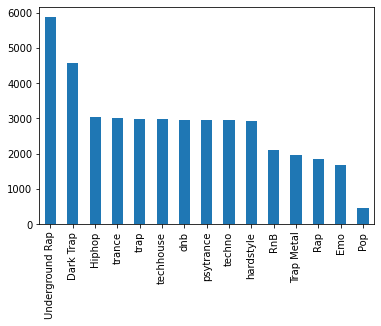

In [ ]:
df.genre.value_counts().plot.bar()   # Because underground Rap & Dark trap are the most frequent genres, we build a simple classifier on that.

In [ ]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000
mean,0.639364,0.762516,5.370240,-6.465442,0.549462,0.136561,0.096160,0.283048,0.214079,0.357101,147.474056,250865.846685,3.972580
std,0.156617,0.183823,3.666145,2.941165,0.497553,0.126168,0.170827,0.370791,0.175576,0.233200,23.844623,102957.713571,0.268342
min,0.065100,0.000243,0.000000,-33.357000,0.000000,0.022700,0.000001,0.000000,0.010700,0.018700,57.967000,25600.000000,1.000000
25%,0.524000,0.632000,1.000000,-8.161000,0.000000,0.049100,0.001730,0.000000,0.099600,0.161000,129.931000,179840.000000,4.000000
50%,0.646000,0.803000,6.000000,-6.234000,1.000000,0.075500,0.016400,0.005940,0.135000,0.322000,144.973000,224760.000000,4.000000
75%,0.766000,0.923000,9.000000,-4.513000,1.000000,0.193000,0.107000,0.722000,0.294000,0.522000,161.464000,301133.000000,4.000000
max,0.988000,1.000000,11.000000,3.148000,1.000000,0.946000,0.988000,0.989000,0.988000,0.988000,220.290000,913052.000000,5.000000


In [ ]:
df["name"]

0                                  Mercury: Retrograde
1                                            Pathology
2                                             Symbiote
3        ProductOfDrugs (Prod. The Virus and Antidote)
4                                                Venom
                             ...                      
42300                                              NaN
42301                                              NaN
42302                                              NaN
42303                                              NaN
42304                                              NaN
Name: name, Length: 42305, dtype: object

In [ ]:
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'id', 'duration_ms', 'time_signature', 'genre', 'name'],
      dtype='object')

In [ ]:
df1 = df.drop(['name', 'id', 'genre'], axis = 1)
df2 = df.drop(['name', 'id', 'genre', 'tempo', 'key', 'duration_ms', 'loudness', 'time_signature'], axis = 1)

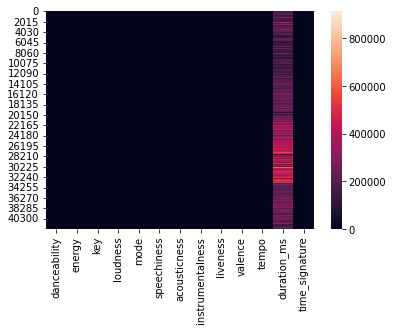

In [ ]:
sns.heatmap(df1)

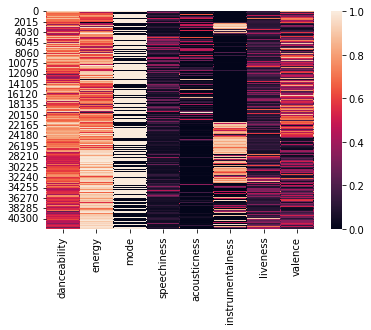

In [ ]:
sns.heatmap(df2)

## Building binary classifier

In [ ]:
# 'name' has missing values and cannot be used for classification because every name only appear once
df.drop(columns = 'name', inplace=True)

In [ ]:
# Define continuous and categorical columns
CONT_COLS = [ 'danceability','energy','loudness','speechiness','acousticness','instrumentalness',
            'liveness','valence','duration_ms']
CAT_COLS = ['genre', 'id', 'tempo', 'time_signature','key']

# make a label for "is_undergroundrap"
df["is_undergroundrap"] = 0
df.loc[df["genre"]=="Underground Rap", "is_undergroundrap"] = 1

# note: time_signature as normal numerlical feature?

In [ ]:
df.dtypes

danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
id                    object
duration_ms            int64
time_signature         int64
genre                 object
is_undergroundrap      int64
dtype: object

In [ ]:
df.genre.value_counts()

Underground Rap    5875
Dark Trap          4578
Hiphop             3028
trance             2999
trap               2987
techhouse          2975
dnb                2966
psytrance          2961
techno             2956
hardstyle          2936
RnB                2099
Trap Metal         1956
Rap                1848
Emo                1680
Pop                 461
Name: genre, dtype: int64

In [ ]:
# labels
y = df["is_undergroundrap"].copy()
# features
x = df.drop(columns =["genre", "is_undergroundrap", "id"]).copy()

In [ ]:
# transform categorical data (mode, key, time_signature) into one-hot-encoded columns

#### Create train and test datasets

In [ ]:
# train test split
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.2, random_state = 42)


In [ ]:
# time signature is probably a categorical varibale (think "blue" and "green")
# categorical variables have to be transformed with One Hot Encoding:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
train_x.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
6863,0.896,0.691,1,-7.403,1,0.369,0.01180,0.000,0.0883,0.6650,189.880,152398,4
30452,0.432,0.962,2,-5.834,1,0.130,0.00193,0.162,0.6300,0.1240,138.010,219085,4
8111,0.686,0.692,0,-5.573,0,0.323,0.48200,0.000,0.1690,0.6490,173.780,269357,3
36665,0.441,0.891,7,-2.873,0,0.037,0.01770,0.815,0.1840,0.0353,175.007,319851,4
4428,0.376,0.876,4,-2.695,0,0.101,0.03450,0.000,0.1250,0.2500,202.082,222442,4


In [ ]:
train_x.shape

(33844, 13)

In [ ]:
valid_x.shape

(8461, 13)

In [ ]:
train_y.head()

6863     1
30452    0
8111     1
36665    0
4428     0
Name: is_undergroundrap, dtype: int64

In [ ]:
train_y.shape

(33844,)

### Classification
#### Random Forest


In [ ]:
# random forest of 500 trees
rf = RandomForestClassifier(
    n_estimators=500, # number of trees you want to build
    bootstrap=True,
    random_state=42
)
rf.fit(train_x, train_y.values.ravel())
rf_preds = rf.predict(valid_x)

In [ ]:
rf_preds

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
print(f'Random Forest Accuracy: {accuracy_score(valid_y, rf_preds)}')

Random Forest Accuracy: 0.8422172320056731


In [ ]:
# possible TODO: find best "hyperparmaeters" to achieve highest accuracy on the test data, good explorations ideas would be n_estimators, max_depth
# use a lop to explore the different hyperparmeters 
# 

# best params from prev search
rf_params = {
    'n_estimators': 100,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features':3,
    'max_depth': 20,
    'bootstrap': True,
    'n_jobs': -1,
    'random_state': 42,
}

rf = RandomForestClassifier(**rf_params)
rf.fit(train_x, train_y.values.ravel())
rf_preds = rf.predict(valid_x)

In [ ]:
print(f'Random Forest Accuracy: {accuracy_score(valid_y, rf_preds)}')

Random Forest Accuracy: 0.840208013237206


### Hyperparameter Tuning

In [ ]:
{"num_est": [50,100]}

{'num_est': [50, 100]}

In [ ]:
# We vary the depth range, and assess the effect on the model accuracies.
# TODO: redo with all sets of parameters and plot, we will have 5 (num_estim) x 5 (max_depths) = 25 entries
num_estimators = [50, 100, 200, 500 ]
depths = [2, 5, 10, 20, 50]
train_errors, valid_errors = [], []

# create dataframe sketch
dat = {}
dat["num_estimators"] =[]
dat["depth"] =[]
dat["train_error"] =[]
dat["valid_error"] =[]

for depth in depths:
  for estimator in num_estimators:
      rf = RandomForestClassifier(max_depth=depth, random_state=42, bootstrap = True, n_estimators=estimator)
      rf.fit(train_x, train_y)
      train_error = accuracy_score(rf.predict(train_x), train_y)
      valid_error = accuracy_score(rf.predict(valid_x), valid_y)
      print(f'Depth: [{depth,estimator}] || Train Accuracy: {train_error} || Validation Accuracy: {valid_error}')

      dat["num_estimators"].append(estimator)
      dat["depth"].append(depth)
      dat["train_error"].append(train_error)
      dat["valid_error"].append(valid_error)

      train_errors.append(train_error)
      valid_errors.append(valid_error)

error_dataframe = pd.DataFrame(dat)

Depth: [(2, 50)] || Train Accuracy: 0.8616298309892447 || Validation Accuracy: 0.8591183075286609
Depth: [(2, 100)] || Train Accuracy: 0.8616298309892447 || Validation Accuracy: 0.8591183075286609
Depth: [(2, 200)] || Train Accuracy: 0.8616298309892447 || Validation Accuracy: 0.8591183075286609
Depth: [(2, 500)] || Train Accuracy: 0.8616298309892447 || Validation Accuracy: 0.8591183075286609
Depth: [(5, 50)] || Train Accuracy: 0.8619548516723792 || Validation Accuracy: 0.8594728755466257
Depth: [(5, 100)] || Train Accuracy: 0.8616593783240751 || Validation Accuracy: 0.8592364968679825
Depth: [(5, 200)] || Train Accuracy: 0.8616298309892447 || Validation Accuracy: 0.8591183075286609
Depth: [(5, 500)] || Train Accuracy: 0.8619548516723792 || Validation Accuracy: 0.8594728755466257
Depth: [(10, 50)] || Train Accuracy: 0.8910294291454911 || Validation Accuracy: 0.8625457983689871
Depth: [(10, 100)] || Train Accuracy: 0.8908816924713391 || Validation Accuracy: 0.8621912303510223
Depth: [(10

In [ ]:
error_dataframe

,num_estimators,depth,train_error,valid_error
0,50,2,0.861630,0.859118
1,100,2,0.861630,0.859118
2,200,2,0.861630,0.859118
3,500,2,0.861630,0.859118
4,50,5,0.861955,0.859473
5,100,5,0.861659,0.859236
6,200,5,0.861630,0.859118
7,500,5,0.861955,0.859473
8,50,10,0.891029,0.862546
9,100,10,0.890882,0.862191


In [ ]:
error_dataframe.round(2)

,num_estimators,depth,train_error,valid_error
0,50,2,0.86,0.86
1,100,2,0.86,0.86
2,200,2,0.86,0.86
3,500,2,0.86,0.86
4,50,5,0.86,0.86
5,100,5,0.86,0.86
6,200,5,0.86,0.86
7,500,5,0.86,0.86
8,50,10,0.89,0.86
9,100,10,0.89,0.86


In [ ]:
error_dataframe['train_error']= error_dataframe['train_error'] * 100
error_dataframe['valid_error']= error_dataframe['valid_error'] * 100

In [ ]:
error_dataframe.round()

,num_estimators,depth,train_error,valid_error
0,50,2,86.0,86.0
1,100,2,86.0,86.0
2,200,2,86.0,86.0
3,500,2,86.0,86.0
4,50,5,86.0,86.0
5,100,5,86.0,86.0
6,200,5,86.0,86.0
7,500,5,86.0,86.0
8,50,10,89.0,86.0
9,100,10,89.0,86.0


[Text(0, 0.5, 'Estimators'), Text(0.5, 0, 'Depth')]

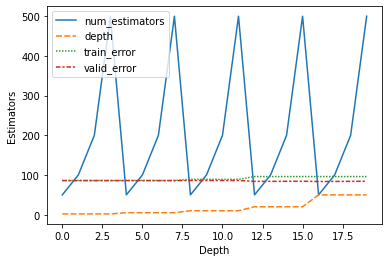

In [ ]:
sns.lineplot(data =error_dataframe ).set(xlabel ="Depth", ylabel ="Estimators")

In [ ]:
# use error_dataframe for plotting
go.Figure(data=[
  go.Scatter(x=list(['depths','num_estimators']), y=train_errors, line_shape='spline', name='train accuracy'),
  go.Scatter(x=list(['depths','num_estimators']), y=valid_errors, line_shape='spline', name='valid accuracy'),
])

In [ ]:

go.Figure(data=[
  go.Scatter(x=list(depths), y=train_errors, line_shape='spline', name='train accuracy'),
  go.Scatter(x=list(depths), y=valid_errors, line_shape='spline', name='valid accuracy'),
])

In [ ]:
# compute feature importances
importance = pd.DataFrame({
    'feature': train_x.columns.tolist(),
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

importance

,feature,importance
0,duration_ms,0.140726
1,danceability,0.112862
2,speechiness,0.108813
3,energy,0.098087
4,tempo,0.094111
5,instrumentalness,0.092605
6,acousticness,0.086025
7,loudness,0.078619
8,valence,0.072927
9,liveness,0.063909


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text major ticklabel objects>)

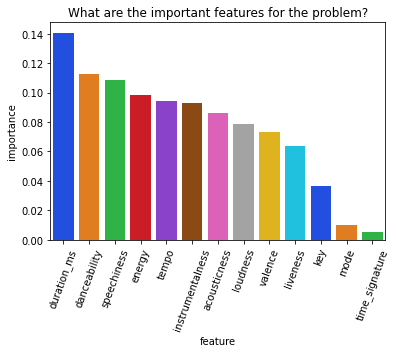

In [ ]:

sns.barplot(data=importance, x ='feature', y='importance',palette = "bright").set(title="What are the important features for the problem?")
plt.xticks(rotation=70)

### Logistic regression

In [ ]:
# Logistic Regression
import sklearn.linear_model as model



In [ ]:
log_reg_woscaler = model.LogisticRegression(max_iter=1000)
log_reg_woscaler.fit(train_x, train_y)

# Logistic regression does not like it when the features (our description columns) have different ranges in their values, 
# e.g. danceability has values btw 0 and 1 and duration_ms has values up to more than 800,000, loudness has negative values
# That means we need to re-scale the features in such a way that they live on the same number range.
# We use here the standard scaler of sklearn, which transforms all features to have a mean of 0 and a standard deviation of 1.
# see https://en.wikipedia.org/wiki/Standard_score

# we use pipleines from sklearn where we put the scaler and the logistic regression into one python-object, called "pipe"
# https://scikit-learn.org/stable/modules/preprocessing.html
log_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
log_reg.fit(train_x, train_y)  # apply scaling on training data


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [ ]:
# Check how the new trained model did
pred = log_reg.predict(valid_x) # make sure that you test with the test set


In [ ]:
print("Accuracy without scaler: ")
print(log_reg_woscaler.score(valid_x, valid_y) )
print("Accuracy with scaler: ")
print(log_reg.score(valid_x, valid_y))


Accuracy without scaler: 
0.8539179765985108
Accuracy with scaler: 
0.8612457156364496


Investigating the logistic regression

In [ ]:
train_x.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature'],
      dtype='object')

In [ ]:
# 8.41e-03 =  8.41 * 10^(-3)= 8.41 * 1/1000
# 10**(-5) = 1/100,000

In [ ]:
#b = a0 + a1*feat1 + a2*feat2

log_reg_woscaler.coef_

array([[ 7.21773302e-05, -1.05118121e-05,  1.79037525e-04,
        -7.09448515e-04,  4.41735486e-05,  3.73134904e-05,
         2.52536368e-05, -5.81601803e-05, -3.62577084e-07,
         4.73033001e-05,  8.41072875e-03, -1.47322771e-05,
         1.78126641e-04]])

In [ ]:
for col in CAT_COLS:
  df[col] = LabelEncoder().fit_transform(df[col])   # Encode categorical variables as dummies

In [ ]:
y = df["genre"].copy()
x =df.drop(columns ="genre").copy()

###Expand to multilabel classification

In [ ]:
## prepare data
# note: ml=multilabel
# labels
y_ml = df["genre"].copy()
# features
x_ml = df.drop(columns =["genre", "is_undergroundrap", "id"]).copy()

# train test split
train_x_ml, valid_x_ml, train_y_ml, valid_y_ml = train_test_split(x_ml, y_ml, test_size=0.2, random_state = 42)

#### Random Forest

In [ ]:
# random forest works automatically also with multiple labels
rf_ml = RandomForestClassifier(
    n_estimators=500, # number of trees you want to build
    bootstrap=True,
    random_state=42
)
rf_ml.fit(train_x_ml, train_y_ml.values.ravel())
rf_preds = rf_ml.predict(valid_x_ml)

In [ ]:
accuracy_score(rf_ml.predict(valid_x_ml), valid_y_ml)

0.6728519087578301

#### Logistic Regression

In [ ]:
# to use multiple labels with logisitc regression one needs to add ' multi_class="multinomial" ' as parameter
log_reg_ml = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, multi_class="multinomial"))
log_reg_ml.fit(train_x_ml, train_y_ml)  # apply scaling on training data

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, multi_class='multinomial'))])

In [ ]:
log_reg_ml.score(valid_x_ml, valid_y_ml)

0.5972107315920104

#### Confusion matrix
Let's inspect how our classification works by inspecting the confusion matrix. the confusion matrix tells us how often the predicted label is correct and how often it is wrong. A good explanation can be found here: 
- https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/ and here 
- https://towardsdatascience.com/visual-guide-to-the-confusion-matrix-bb63730c8eba

In real short a confusion matrix consist of 4 numbers and looks like this:


```
    num1 num2
    num3 num4
```
where `num1` and `num4` are the cases where the classifier predicted the correct label and `num2` and `num3` are the cases where the classifier made a mistake and predicted the wrong label.




In [ ]:
# for plotting I will use the following function taken by https://stackoverflow.com/questions/39033880/plot-confusion-matrix-sklearn-with-multiple-labels
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


#### Confusion matrix for Random Forest

In [ ]:
y_unique = valid_y_ml.unique()
mcm = multilabel_confusion_matrix(rf_ml.predict(valid_x_ml), valid_y_ml, labels=y_unique)
for i in range(15):
  print(y_unique[i])
  print(mcm[i])
  print('')


7
[[6292  568]
 [ 977  624]]

11
[[7816   54]
 [  77  514]]

6
[[7900  280]
 [ 177  104]]

12
[[7793   84]
 [  78  506]]

2
[[7517  369]
 [ 323  252]]

3
[[8343   88]
 [  20   10]]

5
[[7853  249]
 [ 212  147]]

13
[[7789   59]
 [ 110  503]]

10
[[7828   43]
 [  35  555]]

14
[[7812   85]
 [  67  497]]

4
[[8013  235]
 [ 107  106]]

0
[[7102  522]
 [ 389  448]]

8
[[7836    9]
 [  26  590]]

1
[[8025   83]
 [  95  258]]

9
[[7767   40]
 [  75  579]]





HipHop, RnB and Rap are very hard to predict because they have many errors in thier prediction, while e.g. tranc, dnb and Emo mcuh lower errors in their prediction. 

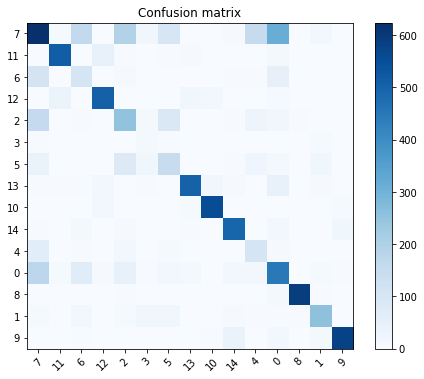

In [ ]:
cm = confusion_matrix(rf_ml.predict(valid_x_ml), valid_y_ml, labels = y_unique)
plot_confusion_matrix(cm, y_unique)

This confusion matrix tells us more abut the error. For example, Dark Trap is often falsely predicted as Underground Rap. Also Hiphop is often falsey predicted to be Underground Rap. 

#### Confsuion Matrix for Logisitc regresssion

In [ ]:
y_unique = valid_y_ml.unique()
multilabel_confusion_matrix(log_reg_ml.predict(valid_x_ml), valid_y_ml, labels = y_unique)
cm = confusion_matrix(log_reg_ml.predict(valid_x_ml), valid_y_ml, labels = y_unique)

In [ ]:
for i in range(15):
  print(y_unique[i])
  print(mcm[i])
  print('')

7
[[6292  568]
 [ 977  624]]

11
[[7816   54]
 [  77  514]]

6
[[7900  280]
 [ 177  104]]

12
[[7793   84]
 [  78  506]]

2
[[7517  369]
 [ 323  252]]

3
[[8343   88]
 [  20   10]]

5
[[7853  249]
 [ 212  147]]

13
[[7789   59]
 [ 110  503]]

10
[[7828   43]
 [  35  555]]

14
[[7812   85]
 [  67  497]]

4
[[8013  235]
 [ 107  106]]

0
[[7102  522]
 [ 389  448]]

8
[[7836    9]
 [  26  590]]

1
[[8025   83]
 [  95  258]]

9
[[7767   40]
 [  75  579]]



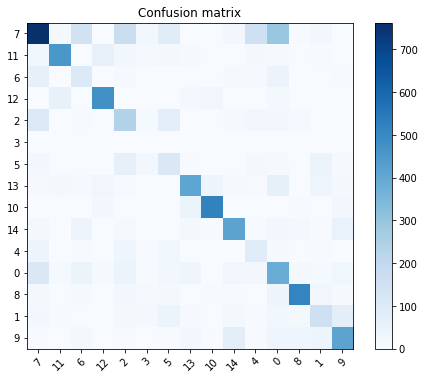

In [ ]:
plot_confusion_matrix(cm, y_unique)

In [ ]:
# End of Project